#### Hank Snowdon
#### Final Project Machine Learning Spring 2024
#### UChicago MSADS
#### Measuring and Identifying High-Difficulty NFL Throws with CNN

In [120]:
import os
import math
import datetime 
  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

import pickle

pd.set_option("display.max_columns", 100)

Data imports 

In [121]:
df_games = pd.read_csv('Data/games.csv')
df_plays = pd.read_csv('Data/plays.csv')
df_players_raw = pd.read_csv('Data/players.csv')
df_scouting = pd.read_csv('Data/pffScoutingData.csv')
df_week_1 = pd.read_csv('Data/week1.csv')
df_week_2 = pd.read_csv('Data/week2.csv')
df_week_3 = pd.read_csv('Data/week3.csv')
df_week_4 = pd.read_csv('Data/week4.csv')
df_week_5 = pd.read_csv('Data/week5.csv')
df_week_6 = pd.read_csv('Data/week6.csv')
df_week_7 = pd.read_csv('Data/week7.csv')
df_week_8 = pd.read_csv('Data/week8.csv')

In [64]:
df_week = pd.concat([df_week_1, df_week_2, df_week_3, df_week_4, df_week_5, df_week_6, df_week_7, df_week_8], ignore_index=True)
df_week.time = pd.to_datetime(df_week.time)

In [65]:
df = df_week.merge(df_games.drop(['gameTimeEastern'], axis = 1), on = "gameId", how = "left" )

In [66]:
df = df.merge(df_plays, on = ["gameId", "playId"], how = 'left')

In [67]:
# Remove penalties
df = df[df.foulName1.isna() ]
# Remove sacks and scrambles 
df = df[(df['passResult'] != 'S') & (df['passResult'] != 'R') ]

In [68]:
df = df.merge(df_players_raw[['nflId', 'displayName']], on = ["nflId"], how = 'left')

In [69]:
# Combine play and game ids so play id is unique 
df['playId'] = df['gameId'].astype(str) + '_' + df['playId'].astype(str)

In [70]:
# Create potential y metrics 
df['touchdown'] = ((df['playDirection'] == 'right') & (df['playResult'] >= (110 - df['absoluteYardlineNumber']))) | ((df['playDirection'] == 'left') & (df['playResult'] >= (df['absoluteYardlineNumber'] - 10)))
df['interception'] = df['passResult'] == 'IN'
df['completion'] = df['passResult'] == 'C'
df['sack'] = df['passResult'] == 'S'

In [71]:
# Next blocks of pre-processing and CNN architecture are largely adapted from:
# https://www.kaggle.com/code/jccampos/nfl-2020-winner-solution-the-zoo/notebook

def split_play_and_player_cols(df,predicting=False): 
     
    player_cols = [
        'playId', 
        'frameId', 
        'jerseyNumber',
        'displayName',
        'team',
        'x',
        'y',
        's',
        'a',
        'dis',
        'dir',
        'o',
        'nflId', 
        'event'
    ]

    df_players = df[player_cols]
    
    play_cols = [ 
        'playId',
        'season',
        'week',
        'possessionTeam',
        'homeTeamAbbr',
        'visitorTeamAbbr',
        'playDirection', 
        'yardlineSide',
        'yardlineNumber',
        'playResult', 
        'touchdown', 
        'interception', 
        'completion'
    ]
 
    df_play = df[play_cols].copy()

 
    # Get first 
    df_play = df_play.groupby('playId').first().reset_index()

    #print('rows/plays in df: ', len(df_play))
    assert df_play.playId.nunique() == df.playId.nunique(), "Play/player split failed?"  # Boom
    
    return df_play, df_players

In [72]:
df_play, df_players = split_play_and_player_cols(df)

In [73]:
# ~6900 plays in the data 
df_play

,playId,season,week,possessionTeam,homeTeamAbbr,visitorTeamAbbr,playDirection,yardlineSide,yardlineNumber,playResult,touchdown,interception,completion
0,2021090900_1078,2021,1,DAL,TB,DAL,right,DAL,7,5,False,False,True
1,2021090900_1203,2021,1,TB,TB,DAL,left,DAL,48,5,False,False,True
2,2021090900_1267,2021,1,TB,TB,DAL,left,DAL,24,17,False,False,True
3,2021090900_1312,2021,1,TB,TB,DAL,left,DAL,2,2,True,False,True
4,2021090900_1368,2021,1,DAL,TB,DAL,right,DAL,25,22,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6929,2021110100_724,2021,8,KC,KC,NYG,right,KC,29,6,False,False,True
6930,2021110100_753,2021,8,KC,KC,NYG,right,KC,35,0,False,False,False
6931,2021110100_775,2021,8,KC,KC,NYG,right,KC,35,0,False,False,False
6932,2021110100_79,2021,8,KC,KC,NYG,right,KC,35,3,False,False,True


In [74]:
def process_yard_til_end_zone(df):
    def convert_to_yardline100(row):
        return (100 - row['yardlineNumber']) if (row['possessionTeam'] == row['yardlineSide']) else row['yardlineNumber']
    df['yardline100'] = df.apply(convert_to_yardline100, axis=1)
    return

process_yard_til_end_zone(df_play)

In [75]:
df_players = df_players.merge(
    df_play[[ 'playId', 'week', 'possessionTeam', 'homeTeamAbbr', 'playDirection', 'yardline100', 'playResult', 'touchdown', 'interception', 'completion']], 
    how='left', on='playId')

In [76]:
# Had to calculate the direction of the football b/c the 2023 data had no football directions
# Direction determined by angle of ball in frame n-1 to frame n 

def calculate_direction(dx, dy):
    dx_array = np.array(dx)
    dy_array = np.array(dy)
    
    directions_rad = np.arctan2(dx_array, dy_array)
    directions_deg = np.degrees(directions_rad).round(2)
    directions_deg[directions_deg < 0] += 360
    
    return directions_deg.tolist()


def update_directions(df):
    
    df_players_sorted = df.sort_values(by=['playId', 'frameId'])
    
    football_rows = df_players_sorted[df_players_sorted['team'] == 'football']
    non_football_rows = df_players_sorted[df_players_sorted['team'] != 'football']
    football_rows.loc[:, 'dir'] = float('nan')

    prev_rows = football_rows.shift(1)
    dx = football_rows['x'] - prev_rows['x']
    dx = dx.fillna(0) 
    dy = football_rows['y'] - prev_rows['y']
    dy = dy.fillna(0) 

    football_rows.loc[:, 'dir'] = calculate_direction(dx, dy)

    football_rows.loc[(football_rows['frameId'] == 1) & (df_players_sorted['playDirection'] == 'right'), 'dir'] = 270
    football_rows.loc[(football_rows['frameId'] == 1) & (df_players_sorted['playDirection'] != 'right'), 'dir'] = 90
    
    updated_df = pd.concat([football_rows, non_football_rows])
    
    return updated_df

df_players = update_directions(df_players)

In [78]:
# Filter to only frames of pass release 
df_players = df_players[df_players['event']=='pass_forward']

In [ ]:
def standarize_direction(df):
    # Adjust the data to always be from left to right
    df['homePossesion'] = df['possessionTeam'] == df['homeTeamAbbr']

    df['dir_rad'] = np.mod(90 - df.dir, 360) * math.pi/180.0

    df['toLeft'] = df.playDirection == "left" 

    df['isOnOffense'] = df.team == df.possessionTeam # Is player on offense?

    df['x_std'] = df.x
    df.loc[df.toLeft, 'x_std'] = 120 - df.loc[df.toLeft, 'x']

    df['y_std'] = df.y
    df.loc[df.toLeft, 'y_std'] = 160/3 - df.loc[df.toLeft, 'y']

    df['dir_std'] = df.dir_rad
    df.loc[df.toLeft, 'dir_std'] = np.mod(np.pi + df.loc[df.toLeft, 'dir_rad'], 2*np.pi)
   
    #Replace Null in dir_rad
    df.loc[(df.isOnOffense) & df['dir_std'].isna(),'dir_std'] = 0.0
    df.loc[~(df.isOnOffense) & df['dir_std'].isna(),'dir_std'] = np.pi

standarize_direction(df_players)

In [84]:
df_players['isBall'] = df_players['team'] == 'football'

/var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ipykernel_35028/316221254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players['isBall'] = df_players['team'] == 'football'


In [85]:
df_players['play_frame_id'] =   df_players['playId'].astype(str) + '_' + df_players['frameId'].astype(str)

/var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ipykernel_35028/4258800401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players['play_frame_id'] =   df_players['playId'].astype(str) + '_' + df_players['frameId'].astype(str)


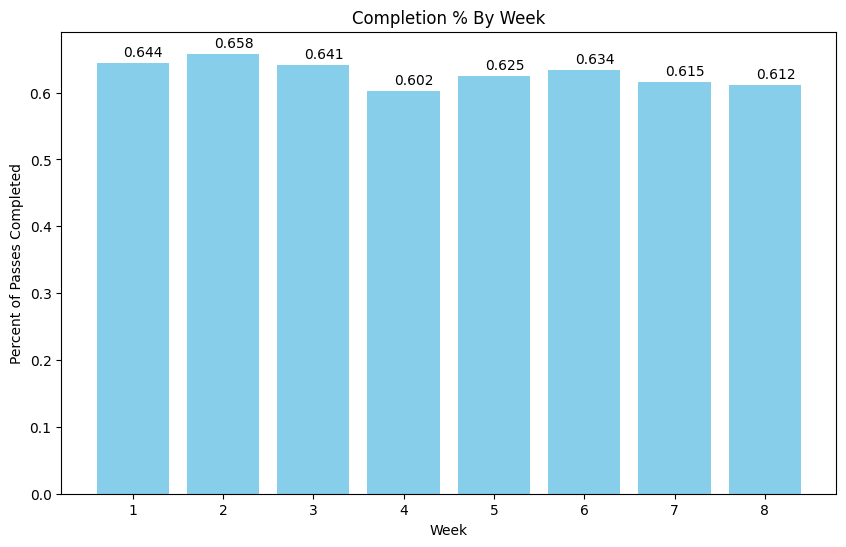

In [86]:
# EDA - Visualize completion rates by week
completion_rates_by_week = df_players.groupby('week')['completion'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(completion_rates_by_week['week'], completion_rates_by_week['completion'], color='skyblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.01, round(yval, 3))

plt.title('Completion % By Week')
plt.xlabel('Week')
plt.ylabel('Percent of Passes Completed') 
plt.show()

In [118]:
# This is taken directly from https://www.kaggle.com/code/huntingdata11/animated-and-interactive-nfl-plays-in-plotly/notebook . Awesome function to plot plays!

colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}
import plotly.graph_objects as go
def animate_play(tracking_df, play_df,players,pffScoutingData, gameId,playId):
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    print(sorted_frame_list)

    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Plot Players
        for team in selected_tracking_df.team.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.team==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Position:{}<br>Role:{}".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName"].values[0],
                                                                                      selected_player_df["pff_positionLinedUp"].values[0],
                                                                                      selected_player_df["pff_role"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hovertext=hover_text_array,hoverinfo="text"))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )

    return fig

In [122]:
# Plot sample play
animate_play(df_week_1,df_plays,df_players_raw,df_scouting,2021090900,97).show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]


In [87]:
# Augment data and process tracking data into variables we need
def data_augmentation(df, sample_ids):
    df_sample = df.loc[df.play_frame_id.isin(sample_ids)].copy()
    df_sample['y_std'] = 160/3  - df_sample['y_std']
    df_sample['dir_std'] = df_sample['dir_std'].apply(lambda x: 2*np.pi - x)
    df_sample['playId'] = df_sample['playId'].apply(lambda x: x+'_aug')
    return df_sample

def process_tracking_data(df):
    # More feature engineering for all:
    df['sx'] = df['s']*df['dir_std'].apply(math.cos)
    df['sy'] = df['s']*df['dir_std'].apply(math.sin)
    
    # ball position
    
    balls = df[df['isBall']].copy()
    balls.set_index(['playId', 'frameId'], inplace=True, drop=True)
    playId_ball_map = balls[['x_std', 'y_std', 'sx', 'sy']].to_dict(orient='index')

    ball_x = df[['playId', 'frameId']].apply(lambda val: playId_ball_map[(val['playId'], val['frameId'])]['x_std'], axis=1)
    ball_y = df[['playId', 'frameId']].apply(lambda val: playId_ball_map[(val['playId'], val['frameId'])]['y_std'], axis=1)
    ball_sx = df[['playId', 'frameId']].apply(lambda val: playId_ball_map[(val['playId'], val['frameId'])]['sx'], axis=1)
    ball_sy = df[['playId', 'frameId']].apply(lambda val: playId_ball_map[(val['playId'], val['frameId'])]['sy'], axis=1)
    
    # Calculate differences between the rusher and the players:
    df.loc[:, 'player_minus_ball_x'] = ball_x - df['x_std']
    df.loc[:, 'player_minus_ball_y'] = ball_y - df['y_std']

    # Velocity parallel to direction of rusher:
    df.loc[:, 'player_minus_ball_sx'] = ball_sx - df['sx']
    df.loc[:, 'player_minus_ball_sy'] = ball_sy - df['sy']

    return(df)


# Split into train and test sets 
df_players_train = df_players[df_players['week'] < 7  ]
df_players_test = df_players[df_players['week'] >= 7 ]


## Train

# This is necessary to maintain the order when in the next cell we use groupby
df_players_train.sort_values(by=['playId', 'frameId'],inplace=True) 


sample_ids = np.random.choice(df_players_train.play_frame_id.unique(), int(1*len(df_players_train.play_frame_id.unique())))
 
df_players_train_aug = data_augmentation(df_players_train, sample_ids)
df_players_train = pd.concat([df_players_train, df_players_train_aug])
df_players_train.reset_index()

df_players_train.sort_values(by=['play_frame_id'],inplace=True) 

df_players_train = process_tracking_data(df_players_train)


## Test 

# This is necessary to maintain the order when in the next cell we use groupby
df_players_test.sort_values(by=['playId', 'frameId'],inplace=True)  

df_players_test = process_tracking_data(df_players_test)

/var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ipykernel_35028/89597920.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players_train.sort_values(by=['playId', 'frameId'],inplace=True)
/var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ipykernel_35028/89597920.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players_test.sort_values(by=['playId', 'frameId'],inplace=True)
/var/folders/hy/7bg3p3w97zz61h5wn9hhp18h0000gn/T/ipykernel_35028/89597920.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [88]:
# Make sure that there are no nulls (other than ball "team")
tracking_level_features = [
    'playId',
    'frameId',
    'displayName',
    'isOnOffense',
    'x_std',
    'y_std',
    'sx',
    'sy',
    'player_minus_ball_x',
    'player_minus_ball_y',
    'player_minus_ball_sx',
    'player_minus_ball_sy',
    'isBall' , 
    'completion'
]

df_all_feats_train = df_players_train[tracking_level_features]
df_all_feats_test = df_players_test[tracking_level_features]


null_counts_train = df_all_feats_train.isnull().sum()
print('Training DataFrame Null Values:')
print(null_counts_train) 

null_counts_test = df_all_feats_test.isnull().sum()
print('Testing DataFrame Null Values:')
print(null_counts_test) 

Training DataFrame Null Values:
playId                     0
frameId                    0
displayName             8677
isOnOffense                0
x_std                      0
y_std                      0
sx                         0
sy                         0
player_minus_ball_x        0
player_minus_ball_y        0
player_minus_ball_sx       0
player_minus_ball_sy       0
isBall                     0
completion                 0
dtype: int64
Testing DataFrame Null Values:
playId                     0
frameId                    0
displayName             1588
isOnOffense                0
x_std                      0
y_std                      0
sx                         0
sy                         0
player_minus_ball_x        0
player_minus_ball_y        0
player_minus_ball_sx       0
player_minus_ball_sy       0
isBall                     0
completion                 0
dtype: int64


In [89]:
# Populate X_train, X_test, y_train, y_test

num_train_samples = len(df_players_train.groupby(['playId', 'frameId']))
num_test_samples = len(df_players_test.groupby(['playId', 'frameId']))

X_train = np.zeros((num_train_samples, 11, 11, 10))
X_test = np.zeros((num_test_samples, 11, 11, 10))
y_train = np.zeros(num_train_samples)
y_test = np.zeros(num_test_samples)

# Function to populate the datasets
def populate_data(grouped, X, y):
    for i, ((playId, frameId), group) in enumerate(grouped):
        offense_data = group[group.isOnOffense]
        defense_data = group[~group.isOnOffense & ~group.isBall]
        
        # Extract offensive data
        off_x = offense_data['x_std'].values
        off_y = offense_data['y_std'].values
        off_sx = offense_data['sx'].values
        off_sy = offense_data['sy'].values
        off_ball_x = offense_data['player_minus_ball_x'].values
        off_ball_y = offense_data['player_minus_ball_y'].values
        off_ball_sx = offense_data['player_minus_ball_sx'].values
        off_ball_sy = offense_data['player_minus_ball_sy'].values

        # Extract defensive data
        def_sx = defense_data['sx'].values
        def_sy = defense_data['sy'].values
        def_x = defense_data['x_std'].values
        def_y = defense_data['y_std'].values

        # Calculate relative positions and speeds
        for j in range(len(offense_data)):
            # Compute relative positions and speeds
            X[i, j, :, :4] = np.column_stack((def_sx, def_sy, def_x, def_y)) - np.array([off_sx[j], off_sy[j], off_x[j], off_y[j]])
            
            # Assign offensive player data for each defensive player matchup
            X[i, j, :, -6:] = np.column_stack((off_ball_sx[j], off_ball_sy[j], off_ball_x[j], off_ball_y[j], off_sx[j], off_sy[j]))

        # Set the completion status for this play and frame
        y[i] = group['completion'].values[0]

# Group the data
grouped_train = df_all_feats_train.groupby(['playId', 'frameId'])
grouped_test = df_all_feats_test.groupby(['playId', 'frameId'])

# Populate X_train, y_train, X_test, and y_test
populate_data(grouped_train, X_train, y_train)
populate_data(grouped_test, X_test, y_test)

In [90]:
# Save the Xs and ys as pickle files 
with open('Data/X_train_rel_array.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open('Data/X_test_rel_array.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open('Data/y_test_rel_array.pkl', 'wb') as f:
    pickle.dump(y_test, f)

with open('Data/y_train_rel_array.pkl', 'wb') as f:
    pickle.dump(y_train, f)

In [96]:
## Load all Xs and ys 

# with open('Data/X_train_array.pkl', 'rb') as f:
#     X_train = pickle.load(f)

# with open('Data/X_test_array.pkl', 'rb') as f:
#     X_test = pickle.load(f)

# with open('Data/y_test_array.pkl', 'rb') as f:
#     y_test = pickle.load(f)

# with open('Data/y_train_array.pkl', 'rb') as f:
#     y_train = pickle.load(f)

In [102]:
# Create initial CNN framework 
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Lambda, AvgPool2D, Conv1D, MaxPooling1D, AvgPool1D, Dense, BatchNormalization, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


def get_CNN():
    inputdense_players = Input(shape=(11,11,10), name="playersfeatures_input")
    
    X = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(inputdense_players)
    X = BatchNormalization()(X)
    X = Conv2D(160, kernel_size=(1,1), strides=(1,1), activation='relu')(X)
    X = BatchNormalization()(X)
    X = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = AvgPool2D(pool_size=(1,11))(X)
    X = Lambda(lambda y: tf.keras.backend.squeeze(y, 2))(X)
    
    X = Conv1D(160, kernel_size=1, strides=1, activation='relu' )(X)
    X = BatchNormalization()(X)
    X = Conv1D(96, kernel_size=1, strides=1, activation='relu' )(X)
    X = BatchNormalization()(X)
    X = Conv1D(96, kernel_size=1, strides=1, activation='relu' )(X)
    X = BatchNormalization()(X)
    
    X = AvgPool1D(pool_size=11)(X)
    X = Lambda(lambda y: tf.keras.backend.squeeze(y, 1))(X)
    
    X = Dense(96, activation="relu" )(X)
    X = BatchNormalization()(X)
    X = Dense(256, activation="relu" )(X)
    X = BatchNormalization()(X)
    X = Dropout(0.3)(X)

    out = Dense(1, activation='sigmoid', name="output")(X)  # Sigmoid for binary classification

    model = Model(inputs=[inputdense_players], outputs=out)

    return model

In [103]:
# Create functions to train models 

from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

# Function to train a single model and return its history
def train_single_model(data, use_early_stopping = False, patience = 10, epochs = 50, batch_size = 16, use_class_weight = False):
    X_train, y_train, X_val, y_val = data
    model = get_CNN()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    callbacks = []
    if use_early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        callbacks.append(early_stopping)

    if use_class_weight:
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weight = dict(enumerate(class_weights))
    else:
        class_weight = None
        

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                           callbacks=callbacks,
                           class_weight=class_weight,
                           verbose=1)
    
    return model, history

def normal_sequential_training(data ,use_early_stopping = False, patience = 10, epochs = 50, batch_size = 16, use_class_weight = False):
    model, history = train_single_model(data, use_early_stopping, patience, epochs, batch_size, use_class_weight)
    
    return model, history


# Function to perform cross-validation training 
def cv_training(X, y, n_splits=5,use_early_stopping = False, patience = 10, epochs = 50, batch_size = 16, use_class_weight = False):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    models = []
    histories = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        data = (X_train, y_train, X_val, y_val)
        model, history = train_single_model(data, use_early_stopping, patience, epochs, batch_size, use_class_weight)
        
        models.append(model)
        histories.append(history)
    
    return models, histories


In [109]:
# Evaluating model functions 

# Function to plot the accuracy for each fold
def plot_accuracy(histories):
    plt.figure(figsize=(14, 10))
    
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label=f'Train Accuracy Fold {i+1}', color='blue')
        plt.plot(history.history['val_accuracy'], label=f'Val Accuracy Fold {i+1}', color='red')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Function to plot the loss for each fold
def plot_loss(histories):
    plt.figure(figsize=(14, 10))
    
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'Train Loss Fold {i+1}', color='blue')
        plt.plot(history.history['val_loss'], label=f'Val Loss Fold {i+1}', color='red')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend()
    plt.show()

# Function to evaluate models on the test data
def evaluate_models(models, X_test, y_test):
    test_accuracies = []
    test_losses = []
    
    for model in models:
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        test_accuracies.append(accuracy)
        test_losses.append(loss)
    
    return np.mean(test_accuracies), np.mean(test_losses) 

Main model

In [105]:
models, histories = cv_training(X_train, y_train, 3 , epochs = 60 )

Epoch 1/60
362/362 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5529 - loss: 0.8361 - val_accuracy: 0.6156 - val_loss: 0.7033
Epoch 2/60
362/362 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6095 - loss: 0.7022 - val_accuracy: 0.5990 - val_loss: 0.7251
Epoch 3/60
362/362 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6094 - loss: 0.6769 - val_accuracy: 0.6229 - val_loss: 0.6652
Epoch 4/60
362/362 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6386 - loss: 0.6446 - val_accuracy: 0.6180 - val_loss: 0.6643
Epoch 5/60
362/362 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6298 - loss: 0.6484 - val_accuracy: 0.6346 - val_loss: 0.6439
Epoch 6/60
362/362 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6572 - loss: 0.6366 - val_accuracy: 0.6374 - val_loss: 0.6503
Epoch 7/60
362/362 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6420 - loss: 0.6391 - val_accuracy: 0.6156 - val_loss: 0.6507
Epoch 8/60
362/362 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6447 - loss: 0.6346 - va

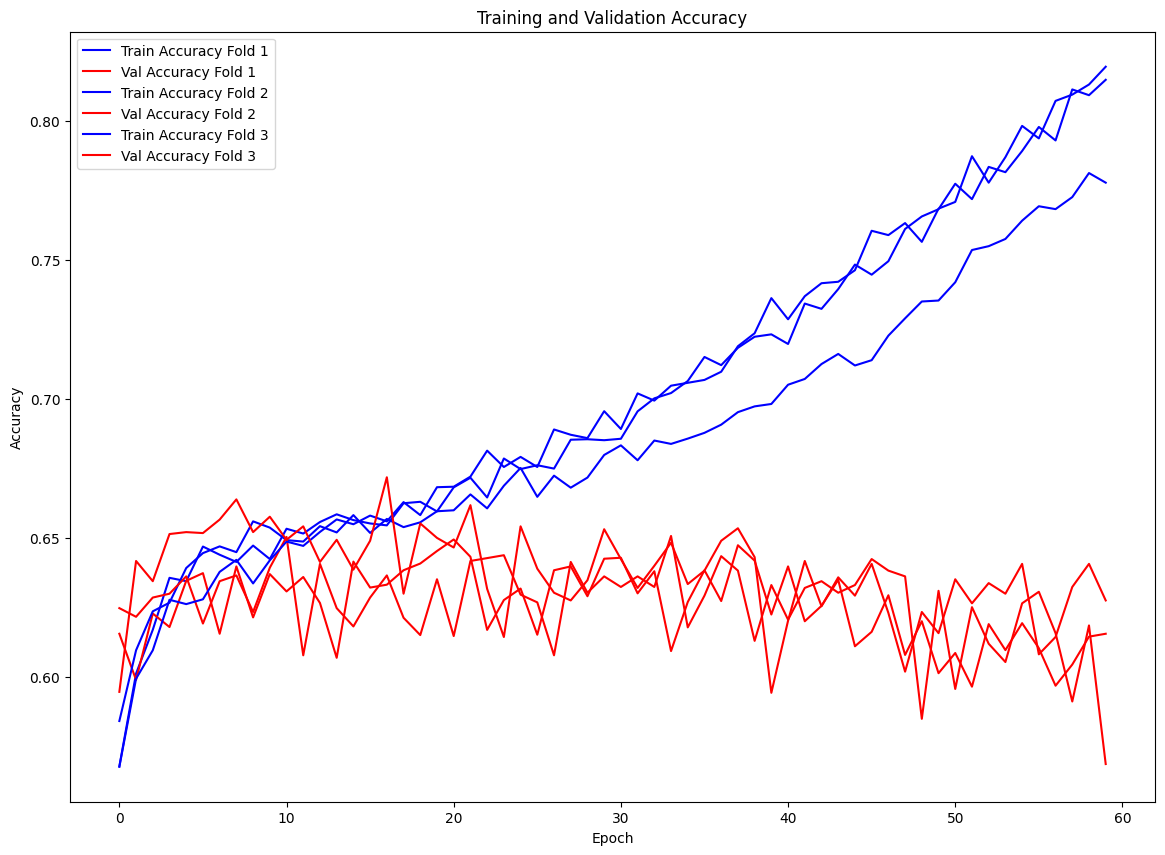

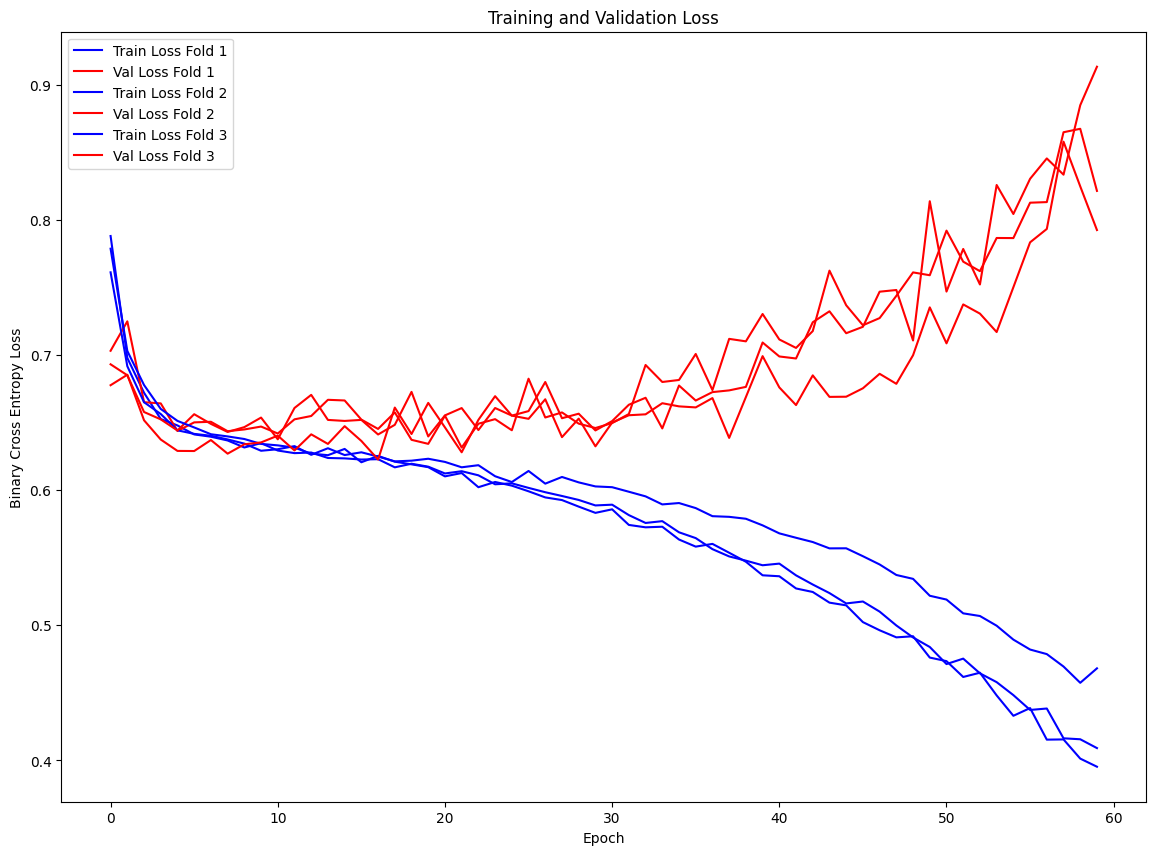

Mean Test Accuracy: 0.5906801223754883
Mean Test Loss: 0.8818193872769674


In [110]:
# Plot the accuracy for each fold
plot_accuracy(histories)
plot_loss(histories)

# Evaluate the models on the test data
mean_accuracy, mean_loss = evaluate_models(models, X_test, y_test)
print(f'Mean Test Accuracy: {mean_accuracy}')
print(f'Mean Test Loss: {mean_loss}')

Updated model to prevent overfitting 

In [111]:
def get_CNN():
    inputdense_players = Input(shape=(11,11,10), name="playersfeatures_input")
    
    X = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu', kernel_regularizer=l2(0.0005))(inputdense_players)
    X = BatchNormalization()(X)
    X = Conv2D(160, kernel_size=(1,1), strides=(1,1), activation='relu', kernel_regularizer=l2(0.0005))(X)
    X = BatchNormalization()(X)
    X = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu', kernel_regularizer=l2(0.0005))(X)
    X = BatchNormalization()(X)
    
    X = AvgPool2D(pool_size=(1,11))(X)
    X = Lambda(lambda y: tf.keras.backend.squeeze(y, 2))(X)
    
    X = Conv1D(160, kernel_size=1, strides=1, activation='relu', kernel_regularizer=l2(0.0005))(X)
    X = BatchNormalization()(X)
    X = Conv1D(96, kernel_size=1, strides=1, activation='relu', kernel_regularizer=l2(0.0005))(X)
    X = BatchNormalization()(X)
    X = Conv1D(96, kernel_size=1, strides=1, activation='relu', kernel_regularizer=l2(0.0005))(X)
    X = BatchNormalization()(X)
    
    X = AvgPool1D(pool_size=11)(X)
    X = Lambda(lambda y: tf.keras.backend.squeeze(y, 1))(X)
    
    X = Dense(96, activation="relu", kernel_regularizer=l2(0.0005))(X)
    X = BatchNormalization()(X)
    X = Dense(256, activation="relu", kernel_regularizer=l2(0.0005))(X)
    X = BatchNormalization()(X)
    X = Dropout(0.6)(X)

    out = Dense(1, activation='sigmoid', name="output")(X)   

    model = Model(inputs=[inputdense_players], outputs=out)

    return model

In [112]:
models2, histories2 = cv_training(X_train, y_train, 3 ,use_early_stopping = True, patience = 10, epochs = 200, batch_size = 16, use_class_weight = False) 

Epoch 1/200
362/362 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.5442 - loss: 1.3846 - val_accuracy: 0.6174 - val_loss: 1.1124
Epoch 2/200
362/362 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5952 - loss: 1.1781 - val_accuracy: 0.6391 - val_loss: 1.0836
Epoch 3/200
362/362 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5955 - loss: 1.1151 - val_accuracy: 0.6229 - val_loss: 1.0601
Epoch 4/200
362/362 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6241 - loss: 1.0544 - val_accuracy: 0.6367 - val_loss: 1.0240
Epoch 5/200
362/362 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6439 - loss: 1.0122 - val_accuracy: 0.6516 - val_loss: 0.9984
Epoch 6/200
362/362 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6293 - loss: 0.9915 - val_accuracy: 0.6502 - val_loss: 0.9575
Epoch 7/200
362/362 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6452 - loss: 0.9545 - val_accuracy: 0.6512 - val_loss: 0.9211
Epoch 8/200
362/362 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.6442 - loss: 0

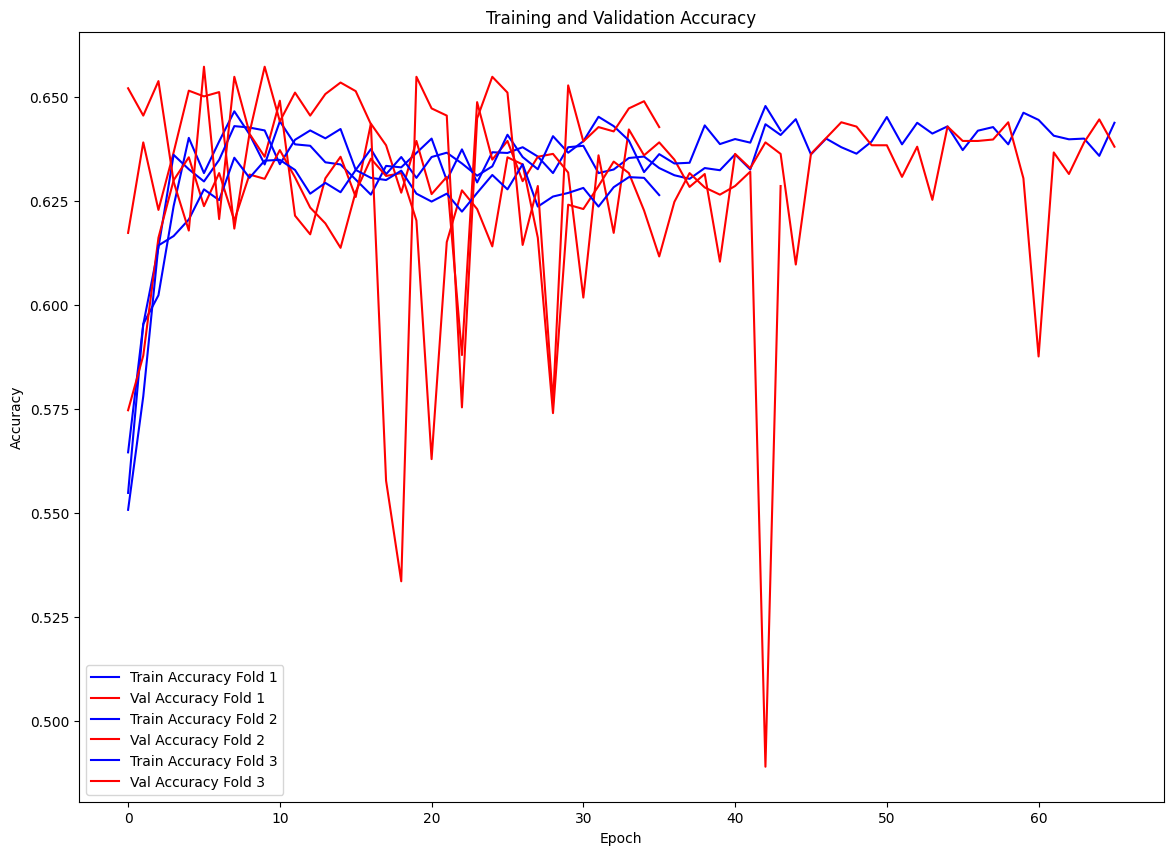

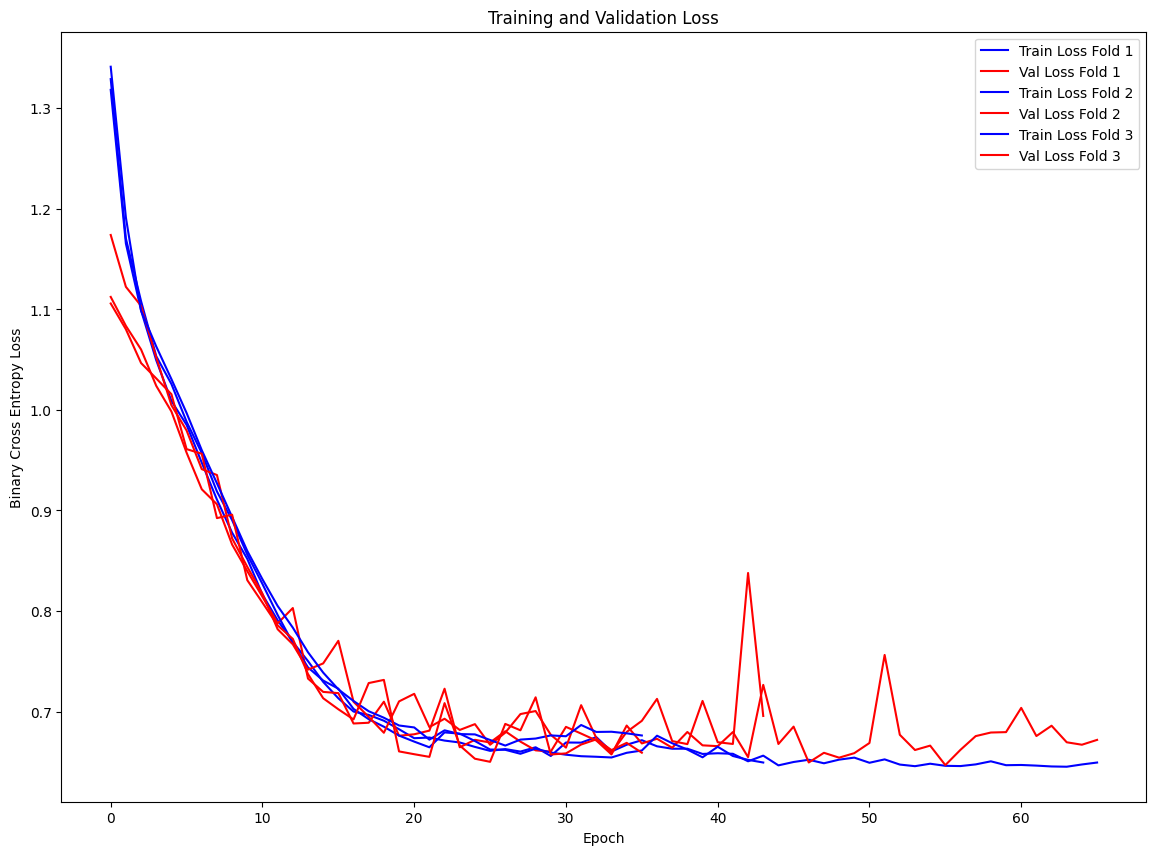

Mean Test Accuracy: 0.6347606976826986
Mean Test Loss: 0.6605466405550638


In [113]:
# Plot the metrics for each fold
plot_accuracy(histories2)
plot_loss(histories2)

# Evaluate the models on the test data
mean_accuracy, mean_loss = evaluate_models(models2, X_test, y_test)
print(f'Mean Test Accuracy: {mean_accuracy}')
print(f'Mean Test Loss: {mean_loss}')


### Generate Predictions

In [114]:
# Generate predictions for each model
predictions_list = [model.predict(X_test) for model in models2] 

predictions_array = np.array(predictions_list)

predicted_probabilities = np.mean(predictions_array, axis=0)

predicted_probabilities_flat = predicted_probabilities.flatten()

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [115]:
# Create clean play file 
play_cols = [ 
    'playId', 
    'week',
    'possessionTeam',
    'homeTeamAbbr', 
    'playDirection',  
    'playResult',  
    'completion'
    ]
 
df_plays_test = df_players_test[play_cols].copy()
  
df_plays_test = df_plays_test.groupby('playId').first().reset_index()

In [116]:
df_plays_test['predicted_completion_probability'] = predicted_probabilities_flat
df_plays_test.loc[df_plays_test['completion'] == True, 'pred_comp_change'] = 1 - df_plays_test['predicted_completion_probability']

In [117]:
# Most unlikely completions weeks 7 and 8
df_plays_test.sort_values(by='pred_comp_change', ascending=False).head(10)

,playId,week,possessionTeam,homeTeamAbbr,playDirection,playResult,completion,predicted_completion_probability,pred_comp_change
1130,2021103106_3784,8,TEN,IND,left,10,True,0.421379,0.578621
534,2021102407_3535,7,PHI,LV,right,17,True,0.430833,0.569167
159,2021102401_324,7,GB,GB,right,17,True,0.442752,0.557248
385,2021102405_2191,7,KC,TEN,right,23,True,0.445903,0.554097
1212,2021103107_3948,8,CIN,NYJ,right,19,True,0.454506,0.545494
620,2021102409_2199,7,TB,TB,right,9,True,0.460692,0.539308
842,2021103101_1780,8,BUF,BUF,left,6,True,0.462032,0.537968
313,2021102404_108,7,CAR,NYG,right,2,True,0.462271,0.537729
339,2021102404_2729,7,NYG,NYG,left,14,True,0.465678,0.534322
248,2021102403_1112,7,NYJ,NE,left,15,True,0.469418,0.530582


In [124]:
# Plot high difficult play
animate_play(df_week_7,df_plays,df_players_raw,df_scouting,2021102405,2191).show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
